*1 Добавить критерий останова


In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [130]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples = 500, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=2, random_state=5)

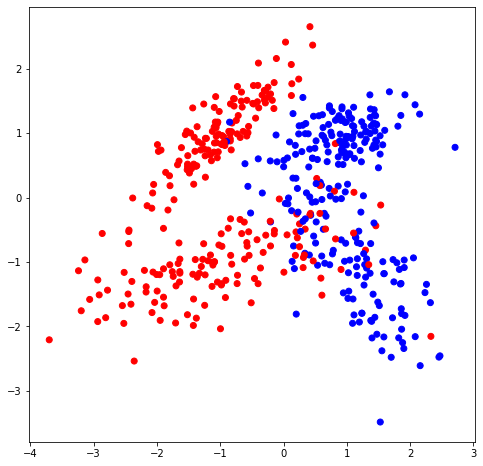

In [131]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [132]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [133]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [134]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [135]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [136]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
    level = 
        
    return true_data, false_data, true_labels, false_labels

In [205]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, min_object_leaf, max_depth, max_leaf):
    
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            ## if len(true_data) < min_leaf or len(false_data) < min_leaf:
                ## continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [181]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels,  min_object_leaf, max_depth, max_leaf):

    quality, t, index = find_best_split(data, labels, min_object_leaf, max_depth, max_leaf)
   
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels,  min_object_leaf, max_depth, max_leaf)
    false_branch = build_tree(false_data, false_labels,  min_object_leaf, max_depth, max_leaf)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [182]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [183]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [184]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [185]:
# Построим дерево по обучающей выборке
find_best_split(train_data, train_labels, min_object_leaf=1, max_depth=5, max_leaf=100)

## min_leaf == 5

##my_tree = build_tree(train_data, train_labels)

## quality, t, index = find_best_split(train_data, train_labels)

(0.31974221267454356, -0.14759001878581768, 0)

In [186]:
my_tree = build_tree(train_data, train_labels, min_object_leaf = 1, max_depth = 5, max_leaf = 100)
my_tree

In [187]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.14759001878581768
--> True:
  Индекс 0
  Порог -0.6155982366664923
  --> True:
    Индекс 0
    Порог -0.9120968201453599
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.8991021894984048
      --> True:
        Прогноз: 1
      --> False:
        Индекс 0
        Порог -0.8527662826329971
        --> True:
          Индекс 0
          Порог -0.8649648226725497
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 1
        --> False:
          Прогноз: 0
  --> False:
    Индекс 1
    Порог 0.5676562331258848
    --> True:
      Индекс 1
      Порог -0.5643473456035233
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 0
--> False:
  Индекс 1
  Порог 1.5936907427978344
  --> True:
    Индекс 1
    Порог 0.29547023387161064
    --> True:
      Индекс 1
      Порог -1.0742068448698225
      --> True:
        Индекс 0
        Порог 2.3192362072770085
        --> Tr

In [188]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [189]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [190]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


In [191]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

100.0

In [192]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

86.66666666666667

Text(0.5, 1.0, 'Test accuracy=86.67')

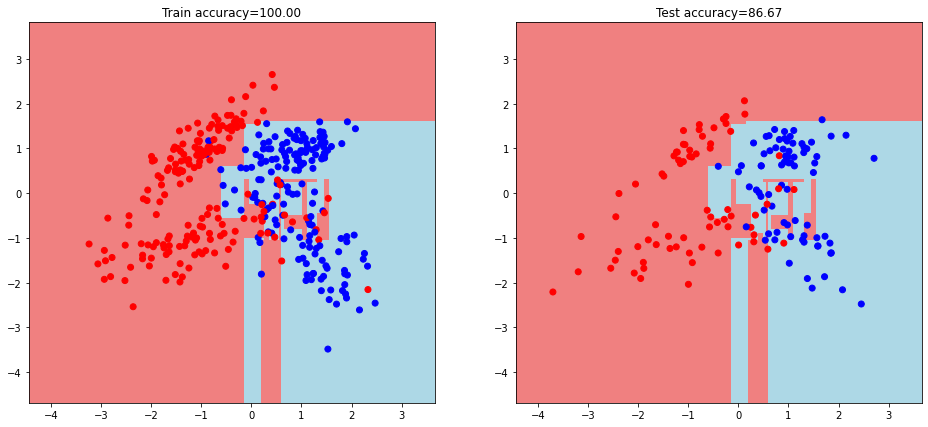

In [193]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [194]:
counter_leaf = 0 # счетчик листьев
counter_node = 0 # счетчик узлов

my_tree = build_tree(train_data, train_labels, min_object_leaf = 1, max_depth = 5, max_leaf = 100)
print('Количество листьев - ', counter_leaf)
print('Количество узлов - ', counter_node)
print ('======tree=======')

print_tree(my_tree)
## Получим ответы для обучающей выборки
train_answer = predict(train_data, my_tree)
## Получим ответы для тестовой выборки
answer = predict(test_data, my_tree)

Количество листьев -  0
Количество узлов -  0
======tree=======
Индекс 0
Порог -0.14759001878581768
--> True:
  Индекс 0
  Порог -0.6155982366664923
  --> True:
    Индекс 0
    Порог -0.9120968201453599
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.8991021894984048
      --> True:
        Прогноз: 1
      --> False:
        Индекс 0
        Порог -0.8527662826329971
        --> True:
          Индекс 0
          Порог -0.8649648226725497
          --> True:
            Прогноз: 0
          --> False:
            Прогноз: 1
        --> False:
          Прогноз: 0
  --> False:
    Индекс 1
    Порог 0.5676562331258848
    --> True:
      Индекс 1
      Порог -0.5643473456035233
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 1
    --> False:
      Прогноз: 0
--> False:
  Индекс 1
  Порог 1.5936907427978344
  --> True:
    Индекс 1
    Порог 0.29547023387161064
    --> True:
      Индекс 1
      Порог -1.0742068448698225
      --> True:


*1 Переделать основание для деления на среднее арифметическое и критерий оценки качества заменить на дисперсию.

In [339]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [340]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        
        prediction = np.mean(self.labels)
        return prediction        

In [341]:
def variance(labels):
    return labels.var()

In [342]:
# Расчет качества

def quality(left_labels, right_labels, current_var):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_var - p * variance(left_labels) - (1 - p) * variance(right_labels)

In [343]:
# Разбиение датасета в узле

def split(data, labels, index, t):
         
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [371]:
def find_best_split_R(data, labels):
    
    min_leaf = 15
    current_var = variance(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_var)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality < best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [372]:
# Построение дерева с помощью рекурсивной функции

def build_tree_R(data, labels):

    quality, t, index = find_best_split_R(data, labels)
   
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_R(true_data, true_labels)
    false_branch = build_tree_R(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [373]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [374]:
def predict_R(data, tree):
    
    values = []
    for obj in data:
        prediction = classify_object(obj, tree)
        values.append(prediction)
    return np.array(values)

In [375]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return
    
    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")   
    

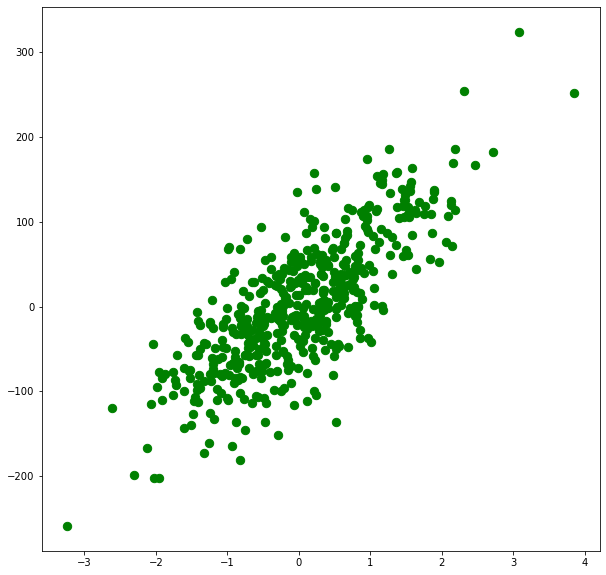

In [376]:
regression_data, regression_labels = datasets.make_regression(n_samples = 500, n_features =1, bias = 5, noise = 50, random_state = 42)

plt.figure(figsize = (10,10))
plt.scatter(regression_data, regression_labels, c = 'green', s =70)

In [377]:
train_dataR, test_dataR, train_labelsR, test_labelsR = model_selection.train_test_split(regression_data, regression_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [378]:
my_tree = build_tree_R(train_dataR,  train_labelsR)
train_answer = predict(train_dataR, my_tree)
test_answer = predict(test_dataR, my_tree)
print_tree(my_tree)

Прогноз: 5.112519153054231


In [368]:
def mse_metric(actual, predicted):
    return np.mean(predicted-actual)**2

In [369]:
train_mse = mse_metric(train_labelsR, train_answer)
train_mse

9.49569580736894e-31

In [370]:
test_mse = mse_metric(test_labelsR, test_answer)
test_mse

30.209381578007584